In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

In [2]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [3]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [4]:
scoring_stats_playoffs = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring', season_type_all_star='Playoffs').get_data_frames()[0]

In [5]:
regular_stats_playoffs = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='PerGame', season_type_all_star='Playoffs').get_data_frames()[0]

In [6]:
scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring').get_data_frames()[0]
regular_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='PerGame').get_data_frames()[0]

In [7]:
regular_stats.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP',
       'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'GP_RANK', 'W_RANK', 'L_RANK',
       'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK',
       'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK',
       'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK',
       'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK',
       'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK',
       'TD3_RANK', 'CFID', 'CFPARAMS'],
      dtype='object')

In [8]:
scoring_columns = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP',
       'W', 'L', 'W_PCT', 'MIN', 'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT',
       'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT',
       'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM',
       'PCT_AST_3PM', 'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']

regular_columns = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP',
       'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']

In [9]:
scoring_stats = scoring_stats.loc[:, scoring_columns]
scoring_stats_playoffs = scoring_stats_playoffs.loc[:, scoring_columns]
regular_stats = regular_stats.loc[:, regular_columns]
regular_stats_playoffs = regular_stats_playoffs.loc[:, regular_columns]

In [10]:
regular_df = pd.merge(left=regular_stats, right=scoring_stats, on=['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION'])

In [11]:
playoff_df = pd.merge(left=regular_stats_playoffs, right=scoring_stats_playoffs, on=['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION'])

In [12]:
target_columns = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'MIN_x', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']

In [13]:
playoff_df = playoff_df.loc[:, target_columns]

In [14]:
regular_df = regular_df.loc[:, target_columns]

In [15]:
playoff_interesting = playoff_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'FGM', 'FGA', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
regular_interesting = regular_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'FGM', 'FGA', 'PCT_AST_FGM', 'PCT_UAST_FGM']]

In [16]:
playoff_interesting.loc[:, 'AST_FGM'] = playoff_interesting.FGM * playoff_interesting.PCT_AST_FGM
playoff_interesting.loc[:, 'UAST_FGM'] = playoff_interesting.FGM * playoff_interesting.PCT_UAST_FGM

In [17]:
regular_interesting.loc[:, 'AST_FGM'] = regular_interesting.FGM * regular_interesting.PCT_AST_FGM
regular_interesting.loc[:, 'UAST_FGM'] = regular_interesting.FGM * regular_interesting.PCT_UAST_FGM

In [18]:
top_playoff = playoff_interesting.sort_values(by='FGM', ascending=False).iloc[:20]

In [19]:
merged_final_df = pd.merge(left=regular_interesting, right=playoff_interesting, on=['PLAYER_ID', 'PLAYER_NAME'], suffixes=('_REGULAR', '_PLAYOFFS'))

In [20]:
merged_final_df.loc[:, "FGA_DIFF"] = merged_final_df.FGA_PLAYOFFS - merged_final_df.FGA_REGULAR

In [22]:
sorted_fga_diff = merged_final_df.sort_values(by='FGA_DIFF', ascending=False)

In [26]:
sorted_fga_diff.loc[sorted_fga_diff.FGA_DIFF > 0].loc[:, ["PLAYER_NAME", "FGA_REGULAR", "FGA_PLAYOFFS"]].iloc[:20]

,PLAYER_NAME,FGA_REGULAR,FGA_PLAYOFFS
198,Timothe Luwawu-Cabarrot,5.7,14.8
123,Luguentz Dort,6.1,12.7
152,Nikola Vucevic,16.7,22.2
207,Tyler Johnson,6.4,11.5
68,Goran Dragic,12.3,17.2
151,Nikola Jokic,14.7,19.5
80,Jamal Murray,15.2,19.8
185,Shake Milton,6.9,11.0
203,Trey Burke,6.3,9.8
62,Gary Clark,3.2,6.6


In [21]:
merged_final_df.sort_values(by='FGA_PLAYOFFS', ascending=False)

,PLAYER_ID,PLAYER_NAME,FGM_REGULAR,FGA_REGULAR,PCT_AST_FGM_REGULAR,PCT_UAST_FGM_REGULAR,AST_FGM_REGULAR,UAST_FGM_REGULAR,FGM_PLAYOFFS,FGA_PLAYOFFS,PCT_AST_FGM_PLAYOFFS,PCT_UAST_FGM_PLAYOFFS,AST_FGM_PLAYOFFS,UAST_FGM_PLAYOFFS
42,1628378,Donovan Mitchell,8.7,19.4,0.326,0.674,2.8362,5.8638,11.9,22.4,0.241,0.759,2.8679,9.0321
152,202696,Nikola Vucevic,8.0,16.7,0.773,0.227,6.1840,1.8160,11.2,22.2,0.714,0.286,7.9968,3.2032
124,1629029,Luka Doncic,9.5,20.6,0.191,0.809,1.8145,7.6855,10.7,21.3,0.094,0.906,1.0058,9.6942
106,202695,Kawhi Leonard,9.3,19.9,0.363,0.637,3.3759,5.9241,10.4,20.5,0.304,0.696,3.1616,7.2384
80,1627750,Jamal Murray,6.9,15.2,0.525,0.475,3.6225,3.2775,9.8,19.8,0.323,0.677,3.1654,6.6346
21,203468,CJ McCollum,8.7,19.4,0.363,0.637,3.1581,5.5419,8.8,19.8,0.295,0.705,2.5960,6.2040
151,203999,Nikola Jokic,7.7,14.7,0.559,0.441,4.3043,3.3957,10.2,19.5,0.614,0.386,6.2628,3.9372
82,201935,James Harden,9.9,22.3,0.153,0.847,1.5147,8.3853,9.1,19.0,0.211,0.789,1.9201,7.1799
89,1628369,Jayson Tatum,8.4,18.6,0.471,0.529,3.9564,4.4436,8.5,18.9,0.387,0.613,3.2895,5.2105
97,203954,Joel Embiid,7.5,15.7,0.521,0.479,3.9075,3.5925,8.5,18.5,0.647,0.353,5.4995,3.0005


In [22]:
merged_final_df.loc[:, 'UAST_DIFF'] = merged_final_df.UAST_FGM_PLAYOFFS - merged_final_df.UAST_FGM_REGULAR

In [23]:
merged_final_df.sort_values(by='UAST_DIFF', ascending=False)

,PLAYER_ID,PLAYER_NAME,FGM_REGULAR,FGA_REGULAR,PCT_AST_FGM_REGULAR,PCT_UAST_FGM_REGULAR,AST_FGM_REGULAR,UAST_FGM_REGULAR,FGM_PLAYOFFS,FGA_PLAYOFFS,PCT_AST_FGM_PLAYOFFS,PCT_UAST_FGM_PLAYOFFS,AST_FGM_PLAYOFFS,UAST_FGM_PLAYOFFS,UAST_DIFF
80,1627750,Jamal Murray,6.9,15.2,0.525,0.475,3.6225,3.2775,9.8,19.8,0.323,0.677,3.1654,6.6346,3.3571
42,1628378,Donovan Mitchell,8.7,19.4,0.326,0.674,2.8362,5.8638,11.9,22.4,0.241,0.759,2.8679,9.0321,3.1683
124,1629029,Luka Doncic,9.5,20.6,0.191,0.809,1.8145,7.6855,10.7,21.3,0.094,0.906,1.0058,9.6942,2.0087
203,203504,Trey Burke,2.8,6.3,0.500,0.500,1.4000,1.4000,5.0,9.8,0.367,0.633,1.8350,3.1650,1.7650
197,203501,Tim Hardaway Jr.,5.4,12.5,0.688,0.313,3.7152,1.6902,6.7,15.8,0.525,0.475,3.5175,3.1825,1.4923
152,202696,Nikola Vucevic,8.0,16.7,0.773,0.227,6.1840,1.8160,11.2,22.2,0.714,0.286,7.9968,3.2032,1.3872
106,202695,Kawhi Leonard,9.3,19.9,0.363,0.637,3.3759,5.9241,10.4,20.5,0.304,0.696,3.1616,7.2384,1.3143
199,202699,Tobias Harris,7.7,16.3,0.570,0.430,4.3890,3.3110,5.8,15.0,0.217,0.783,1.2586,4.5414,1.2304
28,101108,Chris Paul,6.2,12.7,0.175,0.825,1.0850,5.1150,7.9,16.0,0.200,0.800,1.5800,6.3200,1.2050
98,203903,Jordan Clarkson,5.5,12.2,0.454,0.546,2.4970,3.0030,6.4,13.9,0.356,0.644,2.2784,4.1216,1.1186


In [49]:
plt.style.use('fivethirtyeight')

In [54]:
top_playoffs = merged_final_df.sort_values(by='FGM_PLAYOFFS', ascending=False)

In [55]:
top_playoffs = top_playoffs.iloc[:30]

In [64]:
top_playoffs.head()

,PLAYER_ID,PLAYER_NAME,FGM_REGULAR,FGA_REGULAR,PCT_AST_FGM_REGULAR,PCT_UAST_FGM_REGULAR,AST_FGM_REGULAR,UAST_FGM_REGULAR,FGM_PLAYOFFS,FGA_PLAYOFFS,PCT_AST_FGM_PLAYOFFS,PCT_UAST_FGM_PLAYOFFS,AST_FGM_PLAYOFFS,UAST_FGM_PLAYOFFS
42,1628378,Donovan Mitchell,8.7,19.4,0.326,0.674,2.8362,5.8638,11.9,22.4,0.241,0.759,2.8679,9.0321
152,202696,Nikola Vucevic,8.0,16.7,0.773,0.227,6.1840,1.8160,11.2,22.2,0.714,0.286,7.9968,3.2032
124,1629029,Luka Doncic,9.5,20.6,0.191,0.809,1.8145,7.6855,10.7,21.3,0.094,0.906,1.0058,9.6942
106,202695,Kawhi Leonard,9.3,19.9,0.363,0.637,3.3759,5.9241,10.4,20.5,0.304,0.696,3.1616,7.2384
151,203999,Nikola Jokic,7.7,14.7,0.559,0.441,4.3043,3.3957,10.2,19.5,0.614,0.386,6.2628,3.9372


In [72]:
top_playoffs.loc[:, 'UAST_DIFF'] = top_playoffs.UAST_FGM_PLAYOFFS - top_playoffs.UAST_FGM_REGULAR

In [181]:
scoring_columns = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PCT_AST_FGM', 'PCT_UAST_FGM']
regular_columns = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'PTS', 'FGM', 'FGA']
_MERGE_KEY = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION']


def scoring_data(playoff_rounds = [1, 2]):
    scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring').get_data_frames()[0]
    normal_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='PerGame').get_data_frames()[0]
    scoring_stats = scoring_stats.loc[:, scoring_columns]
    normal_stats = normal_stats.loc[:, regular_columns]
    merged_regular = pd.merge(left=normal_stats, right=scoring_stats, on=_MERGE_KEY)
    
    playoff_dfs = []
    merged_final = merged_regular
    merged_final.loc[:, 'UAST_FGM_REGULAR'] = merged_final.PCT_UAST_FGM * merged_final.FGM
    merged_final.loc[:, 'UAST_DIFF_REGULAR'] = 0.0
    for index, playoff_round in enumerate(playoff_rounds):
        scoring_stats_po = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring', season_type_all_star='Playoffs', po_round_nullable=f"{playoff_round}").get_data_frames()[0]
        normal_stats_po = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='PerGame',season_type_all_star='Playoffs', po_round_nullable=f"{playoff_round}").get_data_frames()[0]
        scoring_stats_po = scoring_stats_po.loc[:, scoring_columns]
        normal_stats_po = normal_stats_po.loc[:, regular_columns]
        merged_po = pd.merge(left=normal_stats_po, right=scoring_stats_po, on=_MERGE_KEY)
        merged_final = pd.merge(left=merged_final, right=merged_po, how='inner', on=_MERGE_KEY, suffixes=('', f'_ROUND_{playoff_round}'))
        merged_final.loc[:, f'UAST_FGM_ROUND_{playoff_round}'] = merged_final[f'PCT_UAST_FGM_ROUND_{playoff_round}'] * merged_final[f'FGM_ROUND_{playoff_round}']
        merged_final.loc[:, f'UAST_DIFF_ROUND_{playoff_round}'] = merged_final[f'UAST_FGM_ROUND_{playoff_round}'] - merged_final.UAST_FGM_REGULAR
    
    normal_playoffs = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='PerGame', season_type_all_star='Playoffs').get_data_frames()[0]
    normal_playoffs = normal_playoffs.loc[:, regular_columns]
    scoring_stats_playoffs = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring', season_type_all_star='Playoffs').get_data_frames()[0]
    scoring_stats_playoffs = scoring_stats_playoffs.loc[:, scoring_columns]
    merged_total_po = pd.merge(left=normal_playoffs, right=scoring_stats_playoffs, on=_MERGE_KEY)
    
    
    #merged_final = pd.merge(left=merged_final, right=normal_playoffs, on=_MERGE_KEY, suffixes=('', '_PLAYOFFS'))
    
    
    merged_final = pd.merge(left=merged_final, right=merged_total_po, on=_MERGE_KEY, suffixes=('', '_PLAYOFFS'))
    merged_final.loc[:, f'UAST_FGM_PLAYOFFS'] = merged_final[f'PCT_UAST_FGM_PLAYOFFS'] * merged_final[f'FGM_PLAYOFFS']
    merged_final.loc[:, f'UAST_DIFF_PLAYOFFS'] = merged_final[f'UAST_FGM_PLAYOFFS'] - merged_final.UAST_FGM_REGULAR
    merged_final = merged_final.sort_values(by='PTS_PLAYOFFS', ascending=False)
    return merged_final

In [191]:
merged_both_rounds = scoring_data(playoff_rounds=[1, 2])

In [184]:
def get_non_na_diffs(cur_row):
    dropped = cur_row.dropna()
    target_list = [
        dropped['UAST_DIFF_REGULAR'],
        dropped['UAST_DIFF_ROUND_1'],
    ]
    if 'UAST_DIFF_ROUND_2' in dropped:
        target_list.append(dropped['UAST_DIFF_ROUND_2'])
    return list(range(len(target_list))), target_list

In [195]:
filtered_playoffs = merged_both_rounds.loc[(merged_both_rounds.FGA >= 10) & (merged_both_rounds.FGA_PLAYOFFS >= 10)]

In [228]:
top_players = filtered_playoffs.sort_values(by='UAST_DIFF_PLAYOFFS', ascending=False).iloc[:6]
bottom_players = filtered_playoffs.sort_values(by='UAST_DIFF_PLAYOFFS', ascending=False).iloc[-3:]

In [229]:
others = filtered_playoffs.loc[~filtered_playoffs.PLAYER_ID.isin(top_players.PLAYER_ID.tolist() + bottom_players.PLAYER_ID.tolist())]

In [230]:
bottom_top = pd.concat([top_players, bottom_players])

In [231]:
bottom_top

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,PTS,FGM,FGA,PCT_AST_FGM,PCT_UAST_FGM,...,UAST_FGM_ROUND_2,UAST_DIFF_ROUND_2,GP_PLAYOFFS,PTS_PLAYOFFS,FGM_PLAYOFFS,FGA_PLAYOFFS,PCT_AST_FGM_PLAYOFFS,PCT_UAST_FGM_PLAYOFFS,UAST_FGM_PLAYOFFS,UAST_DIFF_PLAYOFFS
35,1627750,Jamal Murray,1610612743,DEN,59,18.5,6.9,15.2,0.525,0.475,...,4.9786,1.7011,13,26.1,9.8,19.8,0.323,0.677,6.6346,3.3571
44,202695,Kawhi Leonard,1610612746,LAC,57,27.1,9.3,19.9,0.363,0.637,...,5.6856,-0.2385,12,29.4,10.4,20.5,0.304,0.696,7.2384,1.3143
22,201569,Eric Gordon,1610612745,HOU,36,14.4,4.8,12.9,0.684,0.316,...,1.0000,-0.5168,12,17.3,6.0,14.7,0.569,0.431,2.5860,1.0692
28,201609,Goran Dragic,1610612748,MIA,59,16.2,5.4,12.3,0.461,0.539,...,3.1990,0.2884,9,21.1,7.9,17.2,0.521,0.479,3.7841,0.8735
2,203076,Anthony Davis,1610612747,LAL,62,26.1,8.9,17.7,0.632,0.368,...,5.2032,1.9280,10,27.6,9.9,16.9,0.586,0.414,4.0986,0.8234
39,1628369,Jayson Tatum,1610612738,BOS,66,23.4,8.4,18.6,0.471,0.529,...,4.4556,0.0120,11,25.3,8.5,18.9,0.387,0.613,5.2105,0.7669
73,1627783,Pascal Siakam,1610612761,TOR,60,22.9,8.3,18.4,0.486,0.514,...,3.2880,-0.9782,11,17.0,6.5,16.5,0.528,0.472,3.0680,-1.1982
36,201935,James Harden,1610612745,HOU,68,34.3,9.9,22.3,0.153,0.847,...,6.3984,-1.9869,12,29.6,9.1,19.0,0.211,0.789,7.1799,-1.2054
85,201566,Russell Westbrook,1610612745,HOU,57,27.2,10.6,22.5,0.273,0.727,...,4.0014,-3.7048,8,17.9,7.4,17.5,0.390,0.610,4.5140,-3.1922


In [241]:
bottom_top.loc[:, 'COLOR'] = [
    '#FEC524',
    '#1D428A',
    '#CE1141',
    '#41B6E6',
    '#552583',
    '#007A33',
    '#B4975A',
    '#CE1141',
    '#CE1141',
]

bottom_top.loc[:, 'STYLE'] = [
    '-',
    '-',
    '-',
    '-',
    '-',
    '-',
    '-',
    '--',
    ':',
]

In [244]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

In [258]:
bottom_top

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,PTS,FGM,FGA,PCT_AST_FGM,PCT_UAST_FGM,...,GP_PLAYOFFS,PTS_PLAYOFFS,FGM_PLAYOFFS,FGA_PLAYOFFS,PCT_AST_FGM_PLAYOFFS,PCT_UAST_FGM_PLAYOFFS,UAST_FGM_PLAYOFFS,UAST_DIFF_PLAYOFFS,COLOR,STYLE
35,1627750,Jamal Murray,1610612743,DEN,59,18.5,6.9,15.2,0.525,0.475,...,13,26.1,9.8,19.8,0.323,0.677,6.6346,3.3571,#FEC524,-
44,202695,Kawhi Leonard,1610612746,LAC,57,27.1,9.3,19.9,0.363,0.637,...,12,29.4,10.4,20.5,0.304,0.696,7.2384,1.3143,#1D428A,-
22,201569,Eric Gordon,1610612745,HOU,36,14.4,4.8,12.9,0.684,0.316,...,12,17.3,6.0,14.7,0.569,0.431,2.5860,1.0692,#CE1141,-
28,201609,Goran Dragic,1610612748,MIA,59,16.2,5.4,12.3,0.461,0.539,...,9,21.1,7.9,17.2,0.521,0.479,3.7841,0.8735,#41B6E6,-
2,203076,Anthony Davis,1610612747,LAL,62,26.1,8.9,17.7,0.632,0.368,...,10,27.6,9.9,16.9,0.586,0.414,4.0986,0.8234,#552583,-
39,1628369,Jayson Tatum,1610612738,BOS,66,23.4,8.4,18.6,0.471,0.529,...,11,25.3,8.5,18.9,0.387,0.613,5.2105,0.7669,#007A33,-
73,1627783,Pascal Siakam,1610612761,TOR,60,22.9,8.3,18.4,0.486,0.514,...,11,17.0,6.5,16.5,0.528,0.472,3.0680,-1.1982,#B4975A,-
36,201935,James Harden,1610612745,HOU,68,34.3,9.9,22.3,0.153,0.847,...,12,29.6,9.1,19.0,0.211,0.789,7.1799,-1.2054,#CE1141,--
85,201566,Russell Westbrook,1610612745,HOU,57,27.2,10.6,22.5,0.273,0.727,...,8,17.9,7.4,17.5,0.390,0.610,4.5140,-3.1922,#CE1141,:


Text(0, -5, 'Source: stats.nba.com')

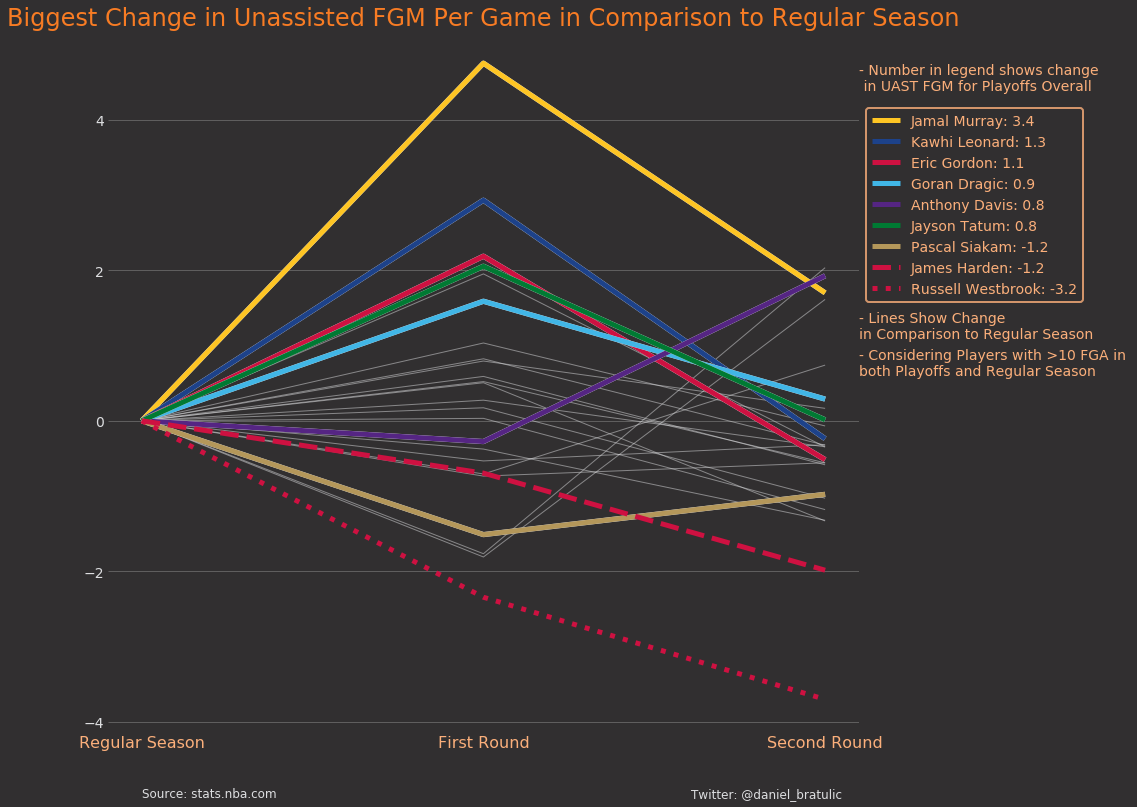

In [302]:
fig, ax = plt.subplots(figsize=(12, 12))

for index in range(len(others)):
    item = others.iloc[index]
    labels, data = get_non_na_diffs(item)
    ax.plot(labels, data, color=bball_white, lw=1, alpha=0.5)
    
for index in range(len(bottom_top)):
    item = bottom_top.iloc[index]
    labels, data = get_non_na_diffs(item)
    if item.STYLE == '-':
        ax.plot(labels, data, color=bball_white, ls=item.STYLE, lw=5.2)
    ax.plot(labels, data, color=item.COLOR, ls=item.STYLE, lw=5, label=f"{item.PLAYER_NAME}: {item.UAST_DIFF_PLAYOFFS:.1f}")


ax.grid(False, axis='x')
ax.grid(True, axis='y', alpha=0.3)
ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)
    
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_light_orange)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)
    tick.set_size(14)
    
ax.set_xticks(range(3))
ax.set_xticklabels(['Regular Season', 'First Round', 'Second Round'], size=16)
ax.set_title("Biggest Change in Unassisted FGM Per Game in Comparison to Regular Season", color=bball_orange, size=24)
ax.text(x=2.1, y=4.4, s='- Number in legend shows change\n in UAST FGM for Playoffs Overall', ha='left', color=bball_light_orange)
ax.text(x=2.1, y=1.1, s='- Lines Show Change\nin Comparison to Regular Season', ha='left', color=bball_light_orange)
ax.text(x=2.1, y=0.6, s='- Considering Players with >10 FGA in \nboth Playoffs and Regular Season', ha='left', color=bball_light_orange)

ax.text(x=2.05, y=-5, s='Twitter: @daniel_bratulic', ha='right', color=bball_white, size=12)
ax.text(x=0, y=-5, s='Source: stats.nba.com', ha='left', color=bball_white, size=12)
#ax.hlines(y=0, xmin=0, xmax=2, lw=5)